# Importing Modules:

In [ ]:
#data import
import kagglehub

#data handling
import pandas as pd
import numpy as np

#data processing/machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, pairwise_distances, confusion_matrix
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

#data visualization
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Importing + Processing Dataset:

## Importing Data:

In [ ]:
def importData():
  #download latest version of the file
  path = kagglehub.dataset_download("vingkan/strategeion-resume-skills")

  #open the resumes_development.csv
  dev_data = pd.read_csv(path + '/resumes_development.csv')
  pilot_data = pd.read_csv(path + '/resumes_pilot.csv')

  #display info on data
  dev_data.info()
  print()
  pilot_data.info()
  print()

  #display shapes
  print(dev_data.shape, pilot_data.shape)

  return dev_data, pilot_data

## Processing Data:

In [ ]:
def processData(data):
  #drop the id columns and missing values
  if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1).dropna()

  #splitting the x and y into features and target
  x = data.iloc[:, 1:]
  y = data.iloc[:, 0]

  #turn all items into pytorch tensors
  x = torch.tensor(x.values, dtype=torch.float32)
  y = torch.tensor(y.values, dtype=torch.float32)

  #printing out the shapes to ensure they match
  print(f"Data Shapes: {x.shape, y.shape}\n")

  #returning the proccessed data
  return x, y

## Scaling/Splitting Data:

In [ ]:
def trainTestScaling(x, y, rstate):
  #standardize features
  scaler = StandardScaler()
  x_scaled = scaler.fit_transform(x)

  #turn into pytorch tensor
  x_scaled = torch.tensor(x_scaled, dtype=torch.float32)

  #train test split
  X_train, X_test, y_train, y_test = train_test_split(
    x_scaled, y, train_size = 0.7, random_state = rstate
  )

  #train test split
  _, unscaled, _, _ = train_test_split(
    x, y, train_size = 0.7, random_state = rstate
  )

  #return data
  return X_train, X_test, y_train, y_test, unscaled

# Preliminary Data Analysis:

## Veteran vs. Civilian Count Analysis:

In [ ]:
def vet_civ_pie(dev_data, pilot_data):
  #calc vet and civ counts for the dev data
  dev_vetCount = dev_data[dev_data['Veteran'] == 1].shape[0]
  dev_civCount = dev_data[dev_data['Veteran'] == 0].shape[0]

  #calc vet and civ counts for pilot data
  pilot_vetCount = pilot_data[pilot_data['Veteran'] == 1].shape[0]
  pilot_civCount = pilot_data[pilot_data['Veteran'] == 0].shape[0]

  #create labels for the plot
  labels = ['Veterans', 'Civilians']

  #get the sizes of each slice of the pie
  dev_sizes = [dev_vetCount, dev_civCount]
  pilot_sizes = [pilot_vetCount, pilot_civCount]

  #create the development plot
  plt.subplot(1, 2, 1)
  plt.pie(dev_sizes, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = ['lightblue', 'pink'])
  plt.title('Development')

  #create the pilot plot
  plt.subplot(1, 2, 2)
  plt.pie(pilot_sizes, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = ['lightblue', 'pink'])
  plt.title('Pilot')

  #display both plots
  plt.tight_layout()
  plt.show()

## Protected Features Count Analysis:

In [ ]:
def computeRates(data):
  #dictionary for results
  results = {}

  #for veterans and then civilians
  for val, name in [(1, 'Veteran'), (0, 'Civilian')]:
    #set temp data to where the veteran status matches
    tempData = data[data['Veteran'] == val]

    #get the total count of vets/civs
    totalCount = len(tempData)

    #if the total count isnt 0 (dummy proofing)
    if(totalCount > 0):
      #get the rates of all females/males, etc etc
      results[name] = {
          'Female': int(tempData['Female'].sum()),
          'Male': int(len(tempData) - tempData['Female'].sum()),
          'URM': int(tempData['URM'].sum()),
          'Non-URM': int(len(tempData) - tempData['URM'].sum()),
          'Disability': int(tempData['Disability'].sum()),
          'Non-Disability': int(len(tempData) - tempData['Disability'].sum())
      }
    #if the total count is 0, set evetything to -
    else:
      results[name] = {
          'Female': 0,
          'Male': 0,
          'URM': 0,
          'Non-URM': 0,
          'Disability': 0,
          'Non-Disability': 0
      }

  #return the rate results
  return results

In [ ]:
def vet_civ_stacked_column(dev_data, pilot_data):
  #compute the counts for dev and pilot
  devCounts = computeRates(dev_data)
  pilotCounts = computeRates(pilot_data)

  #create the categories for the x
  categories = ['Female', 'Male', 'URM', 'Non-URM', 'Disability', 'Non-Disability']
  x = np.arange(len(categories))

  #gets data for development chart
  dev_civVals = [devCounts['Civilian'][cat] for cat in categories]
  dev_vetVals = [devCounts['Veteran'][cat] for cat in categories]

  #so they're side by side
  plt.subplot(1, 2, 1)

  #creates the bars
  plt.bar(x, dev_civVals, 0.5, label = 'Civilian', color = "pink")
  plt.bar(x, dev_vetVals, 0.5, label = 'Veteran', bottom = dev_civVals, color = "lightblue")

  #adds labels
  plt.title('Development')
  plt.xticks(ticks = x, labels = categories, fontsize = 8, rotation = 90)
  plt.legend(loc = 'upper left', fontsize = 8)

  #loop through the categories to create the
  for i in range(len(categories)):
    total_height = dev_civVals[i] + dev_vetVals[i]
    #civilian counts
    plt.text(x[i], dev_civVals[i] / 2,
            str(dev_civVals[i]),
            ha = 'center', va = 'center', fontsize = 7, color = 'black')

    #veteran counts
    plt.text(x[i], total_height - dev_vetVals[i] / 2,
            str(dev_vetVals[i]),
            ha = 'center', va = 'center', fontsize = 7, color = 'black')

  plt.tight_layout()

  #gets data for pilot chart
  pilot_civVals = [pilotCounts['Civilian'][cat] for cat in categories]
  pilot_vetVals = [pilotCounts['Veteran'][cat] for cat in categories]

  #so they're side by side
  plt.subplot(1, 2, 2)

  #creates the bars
  plt.bar(x, pilot_civVals, 0.5, label = 'Civilian', color = "pink")
  plt.bar(x, pilot_vetVals, 0.5, label = 'Veteran', bottom = pilot_civVals, color = "lightblue")

  #adds labels
  plt.title('Pilot')
  plt.xticks(ticks = x, labels = categories, fontsize = 8, rotation = 90)
  plt.legend(loc = 'upper left', fontsize = 8)

  for i in range(len(categories)):
    total_height = pilot_civVals[i] + pilot_vetVals[i]
    #civilian counts
    plt.text(x[i], pilot_civVals[i] / 2,
            str(pilot_civVals[i]),
            ha = 'center', va = 'center', fontsize = 7, color = 'black')

    #veteran counts
    plt.text(x[i], total_height - pilot_vetVals[i] / 2,
            str(pilot_vetVals[i]),
            ha = 'center', va = 'center', fontsize = 7, color = 'black')

  plt.tight_layout()

  #displays the plots
  plt.show()

## Protected Features Intersection Analysis:

In [ ]:
def protected_features_venn_counts(data):
  #initialize the counts for all of the features
  counts = {
      'Female': 0,
      'URM': 0,
      'Disability': 0,
      'Female and URM': 0,
      'Female and Disability': 0,
      'URM and Disability': 0,
      'Female, URM, and Disability': 0
  }

  #go through all the data and based on the protected class, add to the dictionary
  for i in range(len(data)):
      row = data.iloc[i]
      if row['Female']:
        counts['Female'] += 1
      if row['URM']:
        counts['URM'] += 1
      if row['Disability']:
        counts['Disability'] += 1
      if row['Female'] and row['URM']:
        counts['Female and URM'] += 1
      if row['Female'] and row['Disability']:
        counts['Female and Disability'] += 1
      if row['URM'] and row['Disability']:
        counts['URM and Disability'] += 1
      if row['Female'] and row['URM'] and row['Disability']:
        counts['Female, URM, and Disability'] += 1

  #return the dictionary
  return counts


In [ ]:
def protected_features_venn_plots(titles, *counts):
  #get the counts and create the titles
  val_counts = [count for count in counts]
  assert len(titles) == len(val_counts), f"{len(titles)} != {len(val_counts)}"

  #create the venn
  n = len(val_counts)
  for i in range(n):
    plt.subplot(1, n, i + 1)
    venn3(subsets=(tuple(val_counts[i].values())), set_labels=('Female', 'URM', 'Disability'))
    plt.title(titles[i])

  #show the plots
  plt.show()

# Bias Analysis:

In [ ]:
def bias_loss(data, interview):

  prot_feats = ['Female', 'URM', 'Disability']
  unprot_feat = 'Veteran'

  # init state
  sum_loss = 0
  loss_n = 0
  output = {'Female': {
              'Veteran': {'pos_rate': 0, 'neg_rate': 0, 'rate_diff': 0},
              'Civilian': {'pos_rate': 0, 'neg_rate': 0, 'rate_diff': 0}},
            'URM': {
              'Veteran': {'pos_rate': 0, 'neg_rate': 0, 'rate_diff': 0},
              'Civilian': {'pos_rate': 0, 'neg_rate': 0, 'rate_diff': 0}},
            'Disability': {
              'Veteran': {'pos_rate': 0, 'neg_rate': 0, 'rate_diff': 0},
              'Civilian': {'pos_rate': 0, 'neg_rate': 0, 'rate_diff': 0}}}

  # iterate
  for prot_feat in prot_feats:
    for unprot_name, unprot_value in [('Veteran', 1), ('Civilian', 0)]:
      total = data[( data[unprot_feat] == unprot_value)]
      # get matching applicants
      pos_total = total[( total[prot_feat] == 1 )]
      neg_total = total[( total[prot_feat] == 0 )]

      # get matching accepted applicants
      pos_hired = pos_total[( pos_total[interview] == 1 )]
      neg_hired = neg_total[( neg_total[interview] == 1 )]

      # get lengths
      pos_total = len(pos_total)
      neg_total = len(neg_total)
      pos_hired = len(pos_hired)
      neg_hired = len(neg_hired)

      # get loss for this feature
      if (pos_total > 0): # female acceptance rate
        pos_rate = pos_hired / pos_total
      else:
        pos_rate = 0

      if (neg_total > 0): # male acceptance rate
        neg_rate = neg_hired / neg_total
      else:
        neg_rate = 0

      rate_diff = neg_rate - pos_rate
      sum_loss += rate_diff
      loss_n += 1

      output[prot_feat][unprot_name]['pos_rate'] = pos_rate
      output[prot_feat][unprot_name]['neg_rate'] = neg_rate
      output[prot_feat][unprot_name]['rate_diff'] = rate_diff

  return output

# Adjustments:

### Pre-Vet:

In [ ]:
def calcDiff(data, feature):
  #calculates the pos rate
  pos = data[data[feature] == 1]
  if len(pos) > 0:
    posRate = pos['interview'].mean()
  else:
    posRate = 0

  #calculates the neg rate
  neg = data[data[feature] == 0]
  if len(neg) > 0:
    negRate = neg['interview'].mean()
  else:
    negRate = 0

  #returns 0 if they're both 0
  if posRate == 0 and negRate == 0:
    return 0

  #calculates the rate difference
  rateDiff = negRate - posRate

  #returns the rate difference
  return abs(rateDiff)

In [ ]:
def calcAdj(data, feature, lr, epochs):
  adj = 0.0

  #split data into when feature == 1 and 0
  dataPos = data[data[feature] == 1]
  dataNeg = data[data[feature] == 0]

  #get probabilities
  probsPos = dataPos['proba']
  probsNeg = dataNeg['proba']

  for epoch in range(epochs):
    #calculate adjusted probability
    adjProb = probsPos + adj

    #calculate acceptance rates
    accPos = np.mean(adjProb > 0.5)
    accNeg = np.mean(probsNeg > 0.5)

    #check for convergance
    loss = abs(accNeg - accPos)
    if loss < 0.01:
      break

    #update adjustment
    adj += lr * (accNeg - accPos)

  return adj

In [ ]:
def fixProbs(data, feature, vetAdj, civAdj):
  #make sure the probabilities are floats
  data['proba'] = data['proba'].astype(float)

  #loops through all the data
  for i in range(len(data)):
    #checks if the data matches the feature
    if data.iloc[i][feature]:
      #checks veteran status
      if data.iloc[i, data.columns.get_loc('Veteran')] == 1:
        #adds the veteran adjustment
        data.iloc[i, data.columns.get_loc('proba')] += vetAdj
      else:
        #adds the civilian adjustment
        data.iloc[i, data.columns.get_loc('proba')] += civAdj

  #return the updated data
  return data

In [ ]:
def probAdjustment(data, unscaled, probs, preds, y_data, lr_Ac, lr_Av, epochs_A):
  #initializes variables for later
  alphas = {}

  #add predictions and probabilities to a dataframe
  df = pd.DataFrame(unscaled.numpy(), columns = data.columns[2:])
  df['proba'] = probs.numpy()
  df['pred'] = preds.numpy()
  df['interview'] = y_data.numpy()

  #saving the pre adjustment for exportation
  df['pre_proba'] = df['proba'].copy()

  #prot feats and groups
  prot_feats = ['Female', 'URM', 'Disability']
  groups = [('Veteran', 1), ('Civilian', 0)]

  # pre-adjustment bias ratings
  print("Pre-Adjustment Bias Summary\n")
  biasRatings(df, 'pred', prot_feats)

  #print statement for clarity
  print()

  for feat in prot_feats:
    #gets the data for vets and civs
    dataVet = df[df['Veteran'] == 1]
    dataCiv = df[df['Veteran'] == 0]

    #gets the alphas for that feature's vets/civs
    vetAlpha = calcAdj(dataVet, feat, lr_Av, epochs_A)
    civAlpha = calcAdj(dataCiv, feat, lr_Ac, epochs_A)

    #get the difference in rates for vererans and civilians
    vetDiff = calcDiff(dataVet, feat)
    civDiff = calcDiff(dataCiv, feat)

    #updates the alphas dictionary with those values
    alphas[feat] = {'vet': vetAlpha, 'civ': civAlpha, 'vetDiff': vetDiff, 'civDiff': civDiff}

    #updates the probabilities
    df = fixProbs(df, feat, vetAlpha, civAlpha)


  #clips the probabilities so they don't go above 1 or below 0
  df['proba'] = np.clip(df['proba'], 0, 1)

  #saving the post adjustment for exportation
  df['post_proba'] = df['proba']

  #updates the "new interview" feature to have the updated predictions
  df['new_interview'] = (df['proba'] >= 0.5).astype(int)

  #prints the accuracy of the old to new interview scores
  accuracy = accuracy_score(df['interview'], df['new_interview'])
  print(f'Accuracy: {accuracy * 100:.2f}%')

  #post-adjustment bias ratings
  print("Post-Adjustment Bias Summary")
  biasRatings(df, 'new_interview', prot_feats)
  print()


  return df, alphas

### Vet:

In [ ]:
def finalAdjustment(data, feature, tV, tC, threshold, lr=0.01, epochs=5000):
    adj1 = 0.0
    adj2 = 0.0

    # Pos = Vet, Neg = Civ
    dataPos = data[data[feature] == 1]
    dataNeg = data[data[feature] == 0]

    # Get probabilities
    probsPos = dataPos['post_proba']
    probsNeg = dataNeg['post_proba']

    # Initialize accuracy
    accPos = np.mean(probsPos > 0.5)
    accNeg = np.mean(probsNeg > 0.5)

    # Initialize valid checks for thresholds
    valid1 = True
    valid2 = True

    for epoch in range(epochs):
        # Stop scaling when thresholds are met
        if not valid1 and not valid2:
            break

        # Calculate losses if still valid
        if valid1:
            loss1 = abs(tV - accPos)
        if valid2:
            loss2 = abs(tC - accNeg)

        # Adjust for valid1
        if valid1:
            if loss1 < threshold:
                valid1 = False
            else:
                adjProbVet = probsPos - adj1
                accPos = np.mean(adjProbVet > 0.5)
                adj1 += lr * (loss1)

        # Adjust for valid2
        if valid2:
            if loss2 < threshold:
                valid2 = False
            else:
                adjProbCiv = probsNeg + adj2
                accNeg = np.mean(adjProbCiv > 0.5)
                adj2 += lr * (loss2)

        # Log progress every 100 epochs
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss1 + loss2}, Adj1: {adj1}, Adj2: {adj2}')

    return data, adj1, adj2


In [ ]:
def fixProbs2(data, feature, adj1, adj2):
    # Pos = Vet, Neg = Civ
    dataPos = data[data[feature] == 1]
    dataNeg = data[data[feature] == 0]

    # Get probabilities
    probsPos = dataPos['post_proba']
    probsNeg = dataNeg['post_proba']

    new_vet_probas = probsPos - adj1
    new_civ_probas = probsNeg + adj2
    new_probas = pd.concat([new_vet_probas, new_civ_probas]).sort_index()

    # Calculate new interview probabilities
    newer_interview = new_probas.apply(lambda x: 1 if x > 0.5 else 0)
    data.insert(0, 'newer_interview', newer_interview)

    # Final rates
    vet_final_rate = data[data["Veteran"] == 1]["newer_interview"].mean()
    civ_final_rate = data[data["Veteran"] == 0]["newer_interview"].mean()

    #remove newer interview
    if 'newer_interview' in data.columns:
        data = data.drop(columns=['newer_interview'])

    print(f"Vet Final Rate: {vet_final_rate}")
    print(f"Civ Final Rate: {civ_final_rate}")

    return data, new_probas, newer_interview


# Models:

## Basic Logistic Regression:

In [ ]:
def basicRegressor(data):
  x_data, y_data = processData(data)
  x_train, x_test, y_train, y_test, unscaled = trainTestScaling(x_data, y_data, 42)
  model = LogisticRegression()
  model.fit(x_train, y_train)
  acc = accuracy_score(y_test, model.predict(x_test))
  print(f'Accuracy: {acc * 100:.2f}%')
  probs = torch.from_numpy(model.predict_proba(x_test)[:,1])
  preds = torch.where(probs > 0.5, 1, 0)

  return x_data, y_data, model, unscaled, probs, preds, y_test

## Binary Logistic Regression:

In [ ]:
class BinaryLogisticRegression(nn.Module):
  #initializes the model
  def __init__(self, input_dim):
    super(BinaryLogisticRegression, self).__init__()
    #define architecture
    self.network = nn.Sequential(
        #input layer
        nn.Linear(input_dim, 64),
        #apply relu
        nn.ReLU(),
        #dropout to avoid overfitting
        nn.Dropout(p = 0.2),
        #second layer
        nn.Linear(64, 32),
        #relu
        nn.ReLU(),
        #dropout
        nn.Dropout(p = 0.2),
        #output layer
        nn.Linear(32, 1),
        #sigmoid activation (0 - 1)
        nn.Sigmoid()
    )

  #forward pass
  def forward(self, x):
    return self.network(x)

#function to train model
def train_model(model, x_train, y_train, x_test, y_test, criterion, optimizer, epochs):
  #make data for mini batches
  dataset = TensorDataset(x_train, y_train)
  trainLoader = DataLoader(dataset, batch_size = 32, shuffle = True)

  #make variables for checkpointing
  bestParams = None
  bestAccuracy = 0
  patienceCount = 0
  patience = 250

  #loop through specified epochs
  for epoch in range(epochs):
    model.train()
    for batch_idx, (x, y) in enumerate(trainLoader):
      #reset gradients
      optimizer.zero_grad()

      #forward pass
      outputs = model(x)
      loss = criterion(outputs, y.unsqueeze(1))

      #backward pass
      loss.backward()
      optimizer.step()

    #get accuracy
    model.eval()
    with torch.no_grad():
      test_outputs = model(x_test)
      test_predictions = (test_outputs >= 0.5).float()
      test_accuracy = (test_predictions.squeeze() == y_test).float().mean().item() * 100

    #for every 100 epochs, print accuracy
    if (epoch + 1) % 100 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.10f}, Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > bestAccuracy:
      bestAccuracy = test_accuracy
      bestParams = model.state_dict()
      patienceCount = 0
    else:
      patienceCount += 1
      if patienceCount >= patience:
        print(f'Stopping early due to no improvement in {patience} epochs.')
        break

  #get best model
  if bestParams:
    model.load_state_dict(bestParams)
    print(f'Best Model Accuracy: {bestAccuracy:.2f}%')

  #return the best trained model
  return model

#function to make predictions
def predict(model, x_test):
  #disable gradient comp
  with torch.no_grad():
    #get probabilities from the model
    outputs = model(x_test).squeeze()

    #convert probs to 0 or 1
    predictions = (outputs >= 0.5).float()

  #return the predictions and the outputs
  return predictions, outputs

# Miscellanious Helper Functions:

In [ ]:
def biasRatings(data, true, prot_feats):
  #get the bias loss
  bias = bias_loss(data, true)

  #print bias ratings
  for prot_feat in prot_feats:
    for vet_status in ['Veteran', 'Civilian']:
        group = bias[prot_feat][vet_status]
        pos_rate = group['pos_rate'] * 100
        neg_rate = group['neg_rate'] * 100
        rate_diff = group['rate_diff'] * 100
        print(f'{prot_feat} {vet_status} Bias: {neg_rate:.2f}% - {pos_rate:.2f}% = {rate_diff:.2f}%')

# Main Application:

In [ ]:
from re import A
def main():
  ## Importing + Processing Dataset
  # Importing Data
  dev_data, pilot_data = importData()
  # Processing Data
  x, y = processData(dev_data)
  # Scaling Data
  X_train, X_test, y_train, y_test, unscaled = trainTestScaling(x, y, 42)

  # Data Plots
  # Veteran vs Civilian Pie Chart
  vet_civ_pie(dev_data, pilot_data)

  # Veteran vs Civilian Stacked Column Among Protected Classes
  vet_civ_stacked_column(dev_data, pilot_data)

  # Protected Feature Venn DIagrams
  devCounts = protected_features_venn_counts(dev_data)
  pilotCounts = protected_features_venn_counts(pilot_data)
  protected_features_venn_plots(["Development", "Pilot"], devCounts, pilotCounts)

  print()

  # Basic Logistic Regression
  feature_matrix, target_vector, model, unscaled, probs, preds, y_test = basicRegressor(dev_data)

  # Variables for Bias Adjustment:
  lr_Ac = 0.001
  lr_Av = 0.001
  epochs_A = 5000

  # Bias Adjustment #1
  print("\nPerforming Protected Feature Bias Adjustment #1\n")
  df1, alphas1 = probAdjustment(dev_data, unscaled, probs, preds, y_test, lr_Ac, lr_Av, epochs_A)

  # Post-Validation Model Application
  probs = torch.from_numpy(model.predict_proba(feature_matrix)[:,1])
  preds = torch.where(probs > 0.5, 1, 0)

  # Bias Adjustment #2
  print("\nPerforming Protected Feature Bias Adjustment #2\n")
  df2, alphas2 = probAdjustment(dev_data, feature_matrix, probs, preds, target_vector, lr_Ac, lr_Av, epochs_A)

  # Bias Adjustment #3
  df3 = df2.copy()
  print("\nPerforming Civ-Vet Bias Adjustment\n")
  df3, vet_adjust, civ_adjust = finalAdjustment(df3, 'Veteran', 0.75, 0.65, 0.001)
  df3, probs, preds = fixProbs2(df3, 'Veteran', vet_adjust, civ_adjust)

  # Bias Adjustment #4
  print("\nPerforming Final Bias Adjustment\n")
  final_df, alphas3 = probAdjustment(dev_data, feature_matrix, torch.tensor(probs.values), torch.tensor(preds.values), target_vector, lr_Ac, lr_Av, epochs_A)


  return final_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619 entries, 0 to 618
Columns: 224 entries, Unnamed: 0 to Disability
dtypes: float64(219), int64(5)
memory usage: 1.1 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Columns: 224 entries, Unnamed: 0 to Disability
dtypes: float64(223), int64(1)
memory usage: 3.4 MB

(619, 224) (1986, 224)
Data Shapes: (torch.Size([619, 222]), torch.Size([619]))



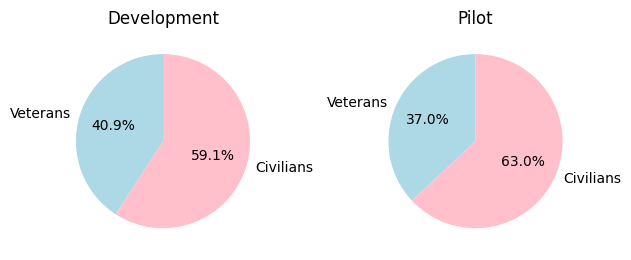

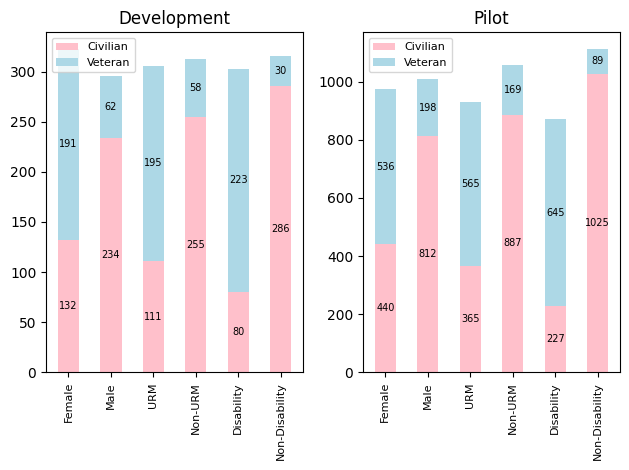

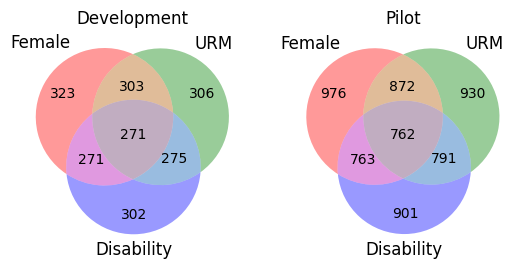


Data Shapes: (torch.Size([619, 222]), torch.Size([619]))

Accuracy: 97.31%

Performing Protected Feature Bias Adjustment #1

Pre-Adjustment Bias Summary

Female Veteran Bias: 100.00% - 65.45% = 34.55%
Female Civilian Bias: 6.94% - 2.44% = 4.51%
URM Veteran Bias: 100.00% - 66.07% = 33.93%
URM Civilian Bias: 6.33% - 2.94% = 3.39%
Disability Veteran Bias: 100.00% - 69.35% = 30.65%
Disability Civilian Bias: 6.67% - 0.00% = 6.67%

Accuracy: 88.71%
Post-Adjustment Bias Summary
Female Veteran Bias: 100.00% - 100.00% = 0.00%
Female Civilian Bias: 6.94% - 4.88% = 2.07%
URM Veteran Bias: 100.00% - 100.00% = 0.00%
URM Civilian Bias: 6.33% - 5.88% = 0.45%
Disability Veteran Bias: 100.00% - 100.00% = 0.00%
Disability Civilian Bias: 6.67% - 4.35% = 2.32%


Performing Protected Feature Bias Adjustment #2

Pre-Adjustment Bias Summary

Female Veteran Bias: 93.55% - 59.69% = 33.86%
Female Civilian Bias: 3.85% - 0.00% = 3.85%
URM Veteran Bias: 94.83% - 60.00% = 34.83%
URM Civilian Bias: 3.53% - 0.00% = 

In [ ]:
final_df = main()

# Final Model Fitting + Analysis:

In [ ]:
x, y = processData(dev_data)

# Change y officially
y = final_df['new_interview']
y = torch.tensor(y.values, dtype = torch.float32)

# Train the Final Model
#scales and splits the data into train/test
x_train, x_test, y_train, y_test, unscaled = trainTestScaling(x, y, 42)

#creates a model, optimizer, and scheduler
model = BinaryLogisticRegression(x_train.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01, weight_decay = 1e-2)

#train the model
model = train_model(model, x_train, y_train, x_test, y_test, criterion, optimizer, 1000)

Data Shapes: (torch.Size([619, 222]), torch.Size([619]))

Epoch [100/1000], Loss: 0.0000001928, Test Accuracy: 75.81%
Epoch [200/1000], Loss: 0.0000000000, Test Accuracy: 73.66%
Epoch [300/1000], Loss: 0.0000000000, Test Accuracy: 74.19%
Stopping early due to no improvement in 250 epochs.
Best Model Accuracy: 80.11%


# Applying Model on Pilot:

In [ ]:
x_analysis, y_analysis = processData(pilot_data)
preds, outs = predict(model, x_analysis)

accuracy = (preds == y_analysis).sum() / len(y_analysis)
print(f'Accuracy: {accuracy * 100:.2f}%')

Data Shapes: (torch.Size([1986, 222]), torch.Size([1986]))

Accuracy: 48.44%


In [ ]:
vet_filter = torch.where(x_analysis[:,218] == 1, True, False)

vet_success = preds[vet_filter]
civ_success = preds[~vet_filter]

vet_success_rate = (vet_success == 1).sum() / len(vet_success)
civ_success_rate = (civ_success == 1).sum() / len(civ_success)

print(f'Veteran Success Rate: {vet_success_rate * 100:.2f}%')
print(f'Civilian Success Rate: {civ_success_rate * 100:.2f}%')

Veteran Success Rate: 99.05%
Civilian Success Rate: 74.36%


In [ ]:
analysis_df = pd.DataFrame(x_analysis.numpy(), columns = pilot_data.columns[2:])
analysis_df['interview'] = y_analysis.float().numpy()

biasRatings(analysis_df, 'interview', ["Female", "URM", "Disability"])

Female Veteran Bias: 100.00% - 63.43% = 36.57%
Female Civilian Bias: 11.70% - 0.23% = 11.47%
URM Veteran Bias: 100.00% - 65.31% = 34.69%
URM Civilian Bias: 10.82% - 0.00% = 10.82%
Disability Veteran Bias: 100.00% - 69.61% = 30.39%
Disability Civilian Bias: 9.27% - 0.44% = 8.83%
